In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
np.random.seed(42)

%matplotlib inline
warnings.filterwarnings('ignore')

In [50]:
bank_data = pd.read_csv('bank-full.csv', sep=';')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Machine Learning Phase

- Categorical  Encodings, As All the Columns represent medium cardinality level I will use OneHotEncoding as the Categorical Encoder.

In [51]:
cols = bank_data.select_dtypes('object').drop('y', axis=1).columns

for col in cols:
    print(col, bank_data[col].nunique())

job 12
marital 4
education 8
default 3
housing 3
loan 3
contact 2
month 10
day_of_week 5
poutcome 3


In [52]:
dummy_df = pd.get_dummies(bank_data[cols]).replace({True:1, False:0})
bank_data.drop(cols, axis=1, inplace=True)
df = pd.concat([bank_data, dummy_df], axis=1)

- Encode the Target column

In [53]:
df['y'] = df['y'].replace({'yes':1, 'no':0})

- Here we check the Multi-colinearity between the columns
- nr.employed, cons.price.idx, euribor3m, pdays, cons.conf.idx	Those columns have very high VIF and this suggests that we should drop (nr.employed, euribor3m)

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.select_dtypes(float)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
4,nr.employed,25472.315833
1,cons.price.idx,21362.906167
3,euribor3m,224.708231
2,cons.conf.idx,116.606231
0,emp.var.rate,28.695222


- nr.employed has higher correlation with the target column so I will drop the cons.price.idx

In [55]:
(df.corr()['y']).sort_values(key=abs).tail(15)

month_sep               0.126067
cons.price.idx         -0.136211
month_oct               0.137366
month_mar               0.144014
contact_cellular        0.144773
contact_telephone      -0.144773
poutcome_nonexistent   -0.193507
previous                0.230181
emp.var.rate           -0.298334
euribor3m              -0.307771
poutcome_success        0.316269
pdays                  -0.324914
nr.employed            -0.354678
duration                0.405274
y                       1.000000
Name: y, dtype: float64

- It's very hard to tell what columns have Multi-Colinearity. so I  will Use PCA for Auto Feature Selection

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,0.906970,0.522034,0.100513,0.945154,1.000000


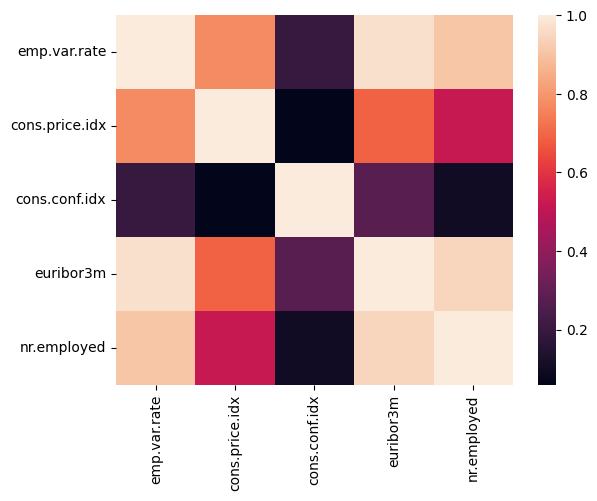

In [56]:
corr = df.select_dtypes(float).corr()
sns.heatmap(corr);
corr

In [57]:
df.drop('nr.employed', axis=1, inplace=True)

- There are some Outliers in our columns we will try to detect them Using The IQR method

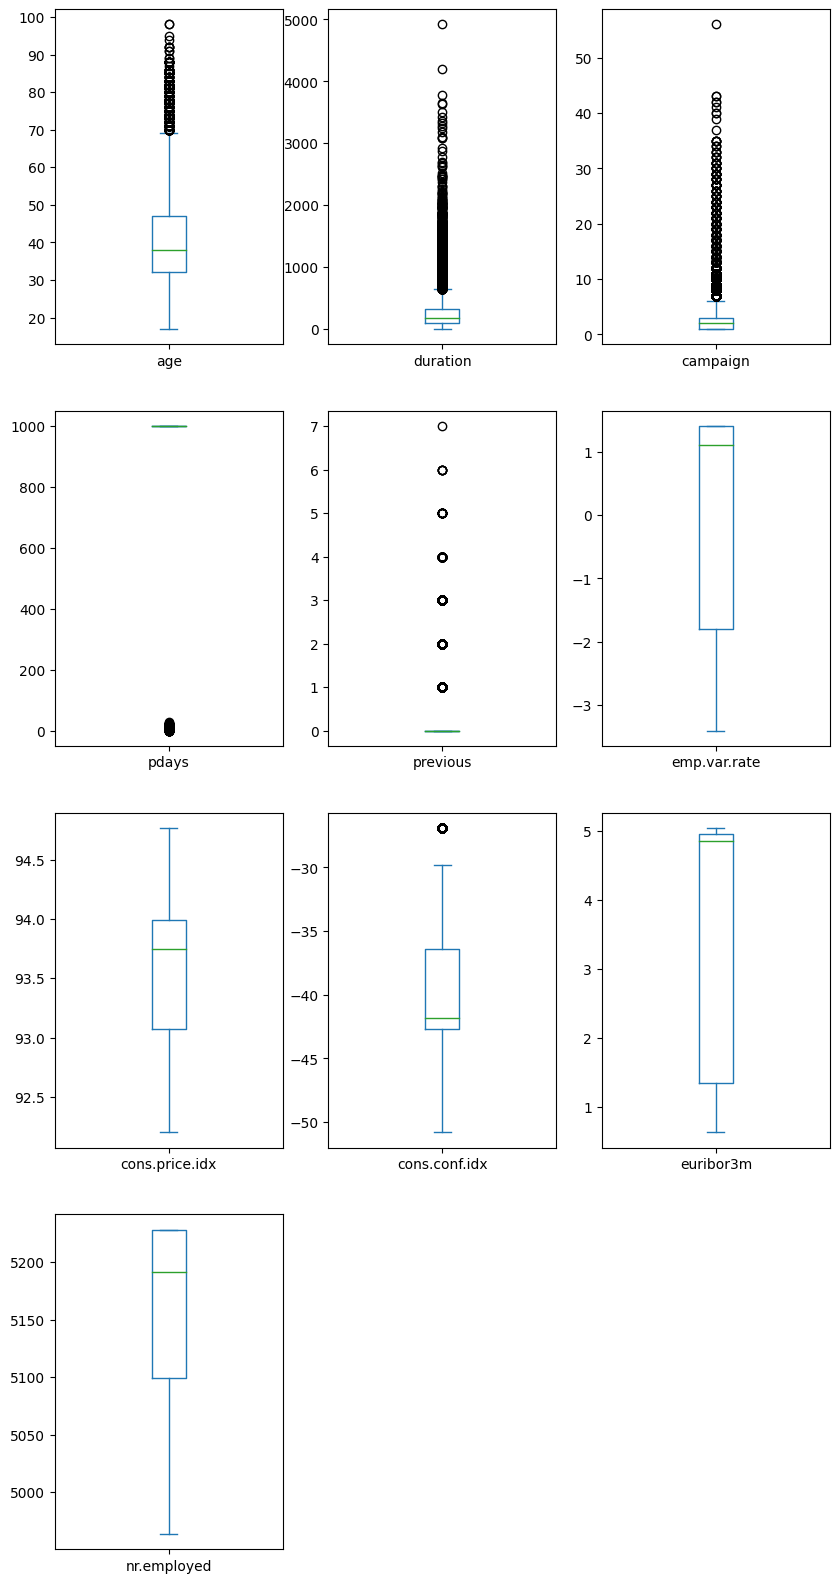

In [58]:
numerical_data = bank_data.select_dtypes(exclude='object')
numerical_data.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(10, 20),  layout=(4, 3))

plt.savefig('figs/Box Plots.png', format='png')

- Getting the indecies of the outliers. I can't Drop all the outliers because the it contains 190 y-yes values so we may drop the y-no rows but keeping the y-yes rows.

In [59]:
q3, q1 = np.percentile(df['cons.conf.idx'], [75, 25])
print(q3, q1)
print(len(df))

IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR

-36.4 -42.7
41188
6.300000000000004


In [60]:
mask1 = df['cons.conf.idx'] > upper_bound
mask2 = df['cons.conf.idx'] < lower_bound

outliers_indecies = df[(mask1) | (mask2)].index

len(outliers_indecies)

447

In [61]:
df.loc[outliers_indecies]['y'].value_counts()

y
0    267
1    180
Name: count, dtype: int64

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.select_dtypes(float)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
1,cons.price.idx,243.333937
3,euribor3m,109.431048
2,cons.conf.idx,93.886029
0,emp.var.rate,19.207868


- Handling the imbalanced target variable.

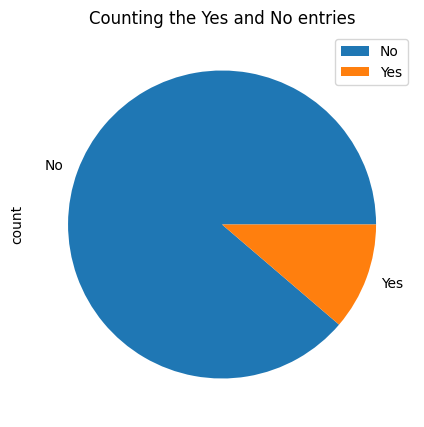

In [63]:
df['y'].value_counts().plot.pie(labels=['No', 'Yes'], figsize=(10, 5))
plt.legend()
plt.title('Counting the Yes and No entries')
plt.savefig('figs/Counting the Yes and No entries.png', format='png')
plt.show()

- Splitting the data

In [64]:
X =  df.drop('y', axis=1)
y = df['y']

- Baseline Accuracy

In [65]:
basline_acc = y.value_counts(normalize=True).max()
print("the Baseline Model", round(basline_acc, 2))

the Baseline Model 0.89


Explained variance ratio of Component 1: 0.6586751679789804
Explained variance ratio of Component 2: 0.33987414723545917
Explained variance ratio of Component 3: 0.0010652624527012263
Explained variance ratio of Component 4: 0.00020938897808252087
Explained variance ratio of Component 5: 7.688828979272255e-05


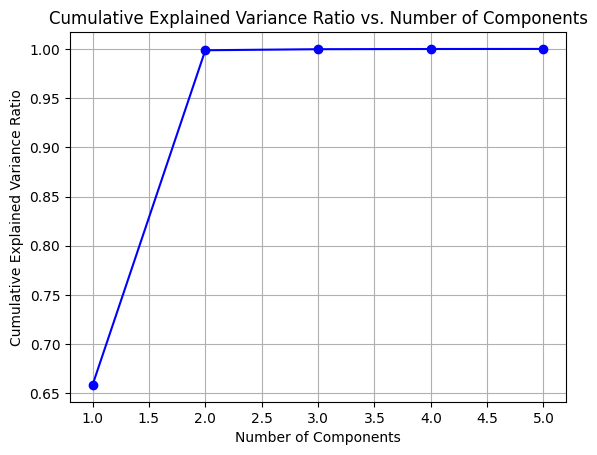

In [66]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=5)  # Choose the number of components
X_pca = pca.fit_transform(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained variance ratio of Component {i+1}: {ratio}")

# Transform the original data using the selected number of components
X = pca.transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

- I will go with the GradientBoostingClassifier.

Knn 0.9007234070133334 0.004995835558116433
svc 0.9066718859233424 0.0029297575040572433
Dtc 0.8834125815623068 0.004937137056795095
Rdf 0.9064533803927075 0.0032191826907049747
adb 0.9038555475513984 0.004315313231412824
grdb 0.9108720877436391 0.0037781600649963764
Gaus 0.9030057000071592 0.0033165191442089477
LDA 0.9031514017998535 0.003244229806730414
LogR 0.9048995315195445 0.0038673274497016265
MLP 0.8992666042466204 0.00844240908852473


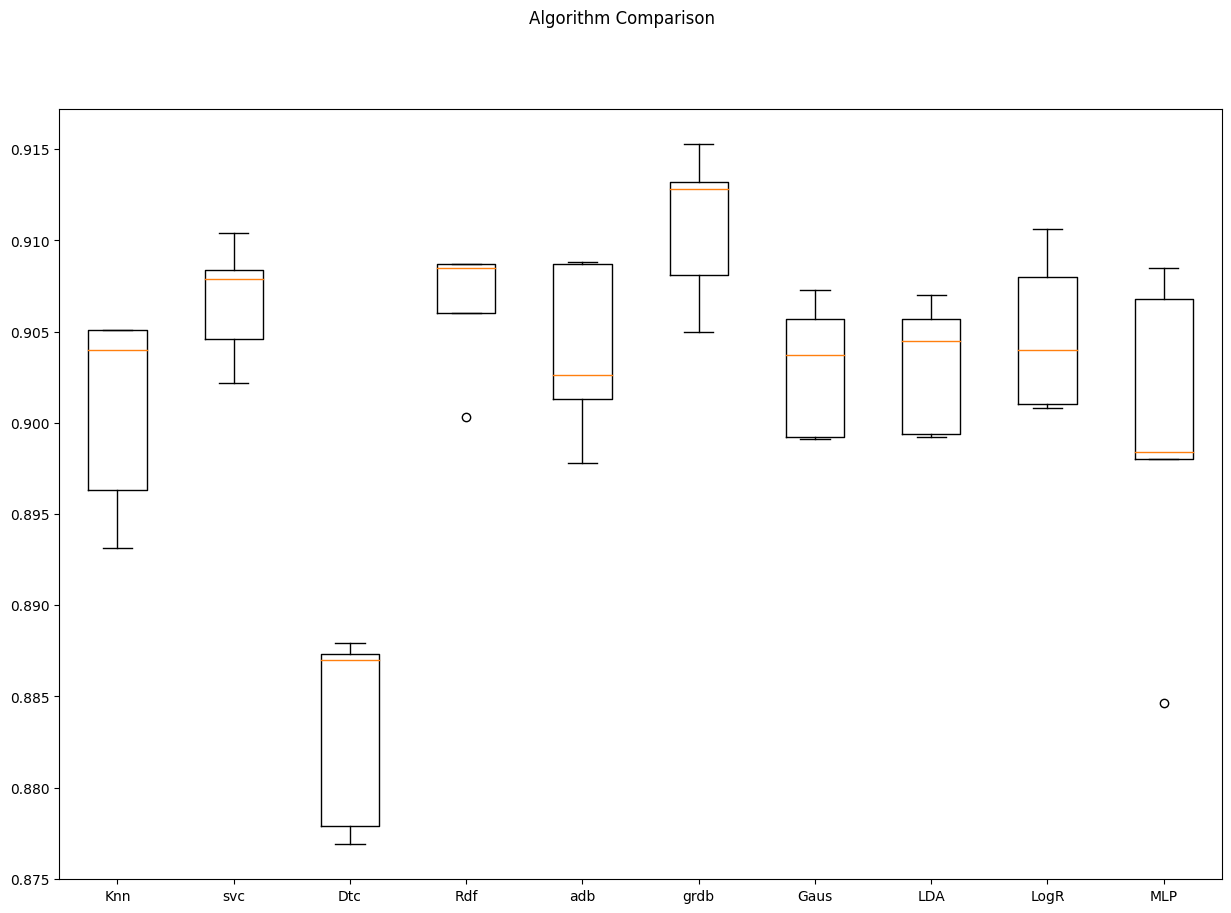

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score

models = [
    ('Knn', KNeighborsClassifier()),
    ('svc', SVC()),
    ('Dtc', DecisionTreeClassifier()),
    ('Rdf', RandomForestClassifier()),
	('adb', AdaBoostClassifier()),
    ('grdb', GradientBoostingClassifier()),
    ('Gaus', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('LogR', LogisticRegression(max_iter=1000)),
    ('MLP', MLPClassifier(max_iter=1000))
]
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name, cv_results.mean(), cv_results.std())
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figs/Models Comparison.png',  format='png')
plt.show()

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

under_samp = RandomUnderSampler()
over_samp = RandomOverSampler()
smote = SMOTE()

X_under, y_under = under_samp.fit_resample(X_train, y_train)
X_over, y_over = over_samp.fit_resample(X_train, y_train)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

- The Results Suggests that we go with the Original X_train, y_train sets.

In [70]:
model_under = GradientBoostingClassifier().fit(X_under, y_under)
print(model_under.score(X_test, y_test))

model_over = GradientBoostingClassifier().fit(X_over, y_over)
print(model_over.score(X_test, y_test))

model_smote = GradientBoostingClassifier().fit(X_smote, y_smote)
print(model_smote.score(X_test, y_test))

model_original = GradientBoostingClassifier().fit(X_train, y_train)
print(model_original.score(X_test, y_test))

0.8459577567370721
0.8534838553046856
0.8503277494537509
0.9118718135469774


-  After  the random over sampling

In [71]:
# y_over.value_counts().plot.pie(labels=['NO', 'Yes'], figsize=(10, 5))
# plt.legend()
# plt.title('Counting the Yes and No entries After RandomOverSampler')
# plt.savefig('figs/Counting the Yes and No entries After RandomOverSampler.png', format='png')
# plt.show()

In [72]:
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluating the model with the Classification Metrics
pred = model_original.predict(X_test)

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[7064  239]
 [ 487  448]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      7303
           1       0.65      0.48      0.55       935

    accuracy                           0.91      8238
   macro avg       0.79      0.72      0.75      8238
weighted avg       0.90      0.91      0.91      8238

Area Under Curve : 
 0.7232090540771099


In [73]:
from sklearn.model_selection import GridSearchCV


# Create the GradientBoostingClassifier
clf = GradientBoostingClassifier()

# Define the hyperparameter grid
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(50, 100, 10),
    'max_depth': range(3, 6)
}

# Perform grid search using cross-validation
model = GridSearchCV(clf, param_grid=params, cv=5, verbose=1)

# Fit the grid search to the data
model.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", model.best_params_)
print("Best Score:", model.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 60}
Best Score: 0.9104097116843702


In [74]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.724039,0.051247,0.004822,0.000425,0.1,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.908042,0.906373,0.907436,0.913202,0.914719,0.909954,0.003349,6
1,4.468422,0.069188,0.006213,0.000961,0.1,3,60,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.909408,0.907284,0.907132,0.912898,0.914264,0.910197,0.002910,4
2,5.415845,0.134103,0.007193,0.000394,0.1,3,70,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.910167,0.907739,0.907739,0.912898,0.913354,0.910379,0.002416,2
3,6.767330,0.305674,0.008787,0.001444,0.1,3,80,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.908801,0.907132,0.907739,0.913354,0.912595,0.909924,0.002558,7
4,8.155380,0.543682,0.009179,0.001460,0.1,3,90,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.908953,0.907587,0.907436,0.911684,0.913657,0.909863,0.002434,9


In [75]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.9262
Model Test Accuracy: 0.9121


In [76]:
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluating the model with the Classification Metrics
pred = model.predict(X_test)

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[7044  259]
 [ 465  470]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      7303
           1       0.64      0.50      0.56       935

    accuracy                           0.91      8238
   macro avg       0.79      0.73      0.76      8238
weighted avg       0.90      0.91      0.91      8238

Area Under Curve : 
 0.7336044596719098


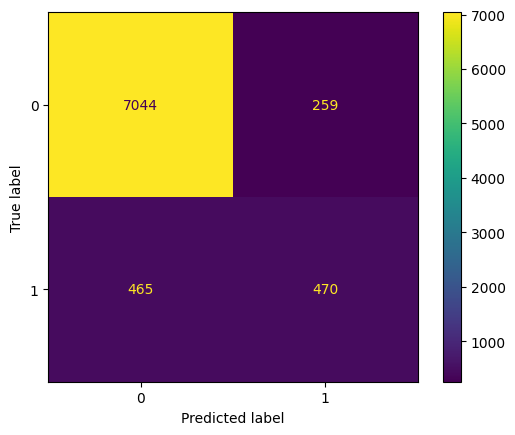

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

plt.savefig("figs/5-5-16.png", dpi=150)

In [80]:
# # Get feature names from training data
# features = X_train.columns

# # Extract importances from model
# importances = model.best_estimator_.feature_importances_

# # Create a series with feature names and importances
# feat_imp = pd.Series(importances, index=features).sort_values()

# # Plot 10 most important features
# feat_imp.tail(15).plot(kind='barh')

# plt.xlabel("Gini Importance")
# plt.ylabel("Feature")
# plt.title("Feature Importance");
# # Don't delete the code below 👇
# plt.savefig("figs/5-5-17.png", dpi=150)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [81]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [82]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9121145909201263
